In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.plotly as py
from plotly.graph_objs import *
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from bokeh.io import show, output_file, output_notebook
from bokeh.models import FactorRange
from bokeh.plotting import figure

from collections import defaultdict

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

plt.rcParams['figure.figsize'] = (15, 6)

There are four different .csv files for this project:
* **station.csv** - this reflects the different bike sharing stations in the bay area, including station name, coordinates, capacity, city, and installation date
* **trip.csv** - this includes dates and routes for trips taken over a two-year period between Aug-2013 and Aug-2015
* **weather.csv** - this provides weather information for different zip codes over the same period of time as the trip.csv table
* **status.csv** - this includes minute by minute bike availability information for each of the 35 stations.

# Read in and clean data

### Station

In [2]:
station = pd.read_csv('data/station.csv', parse_dates = ['installation_date'])

In [3]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-05
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-05
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07


In [4]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int64
name                 70 non-null object
lat                  70 non-null float64
long                 70 non-null float64
dock_count           70 non-null int64
city                 70 non-null object
installation_date    70 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 3.9+ KB


In [5]:
# Check for duplicate rows
station.duplicated().sum()

0

### Trip

In [6]:
trip = pd.read_csv('data/trip.csv', parse_dates = ['start_date', 'end_date'])

In [7]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103


In [8]:
# Convert duration to minutes from seconds
trip['duration'] = trip['duration']/60

In [9]:
# Check for duplicate rows
trip.duplicated().sum()

0

In [10]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 11 columns):
id                    669959 non-null int64
duration              669959 non-null float64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 56.2+ MB


Zip codes has missing values in the dataframe based on the values above. Let's take a closer look at the problem

In [11]:
trip['zip_code'].value_counts()[:10]

94107    78704
94105    42672
94133    31359
94103    26673
94111    21409
94102    19757
94109    13989
95112    11564
nil      10682
94117     9851
Name: zip_code, dtype: int64

As can be seen above, zip code has various values, many of which do not represent zip codes. Since zip code is a measure of location, let's drop the zip code column and replace it with a column that indicates the city.

In [12]:
# Some of the trips have taken longer than 24 hours to complete. This is probably an error so let's filter out those values.
base = trip.shape
print('Prior to filtering for trip duration: {}'.format(base))

Prior to filtering for trip duration: (669959, 11)


In [13]:
minutes_in_a_day = 60 * 24
trip = trip[trip['duration'] < minutes_in_a_day]

print('After filtering for trip duration: {}'.format(trip.shape))

After filtering for trip duration: (669663, 11)


In [14]:
# Create station id to city dictionary
id_city_dict = dict(zip(station['id'], station['city']))

# Add city column to trip dataframe
trip['city'] = trip['start_station_id'].map(id_city_dict)

In [15]:
# Drop duration and zip_code columns
trip = trip.drop(['zip_code'], axis=1)

In [16]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669663 entries, 0 to 669958
Data columns (total 11 columns):
id                    669663 non-null int64
duration              669663 non-null float64
start_date            669663 non-null datetime64[ns]
start_station_name    669663 non-null object
start_station_id      669663 non-null int64
end_date              669663 non-null datetime64[ns]
end_station_name      669663 non-null object
end_station_id        669663 non-null int64
bike_id               669663 non-null int64
subscription_type     669663 non-null object
city                  669663 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 61.3+ MB


In [17]:
trip_clean = trip[:]

### Weather

In [18]:
weather = pd.read_csv('data/weather.csv', parse_dates = ['date'])

In [19]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [20]:
# What are the columns of interested for this dataset?
weather.columns

Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code'],
      dtype='object')

In [21]:
# Choose columns to keep 
to_keep = ['date', 'mean_temperature_f', 'mean_wind_speed_mph', 'precipitation_inches', 'zip_code']

weather = weather[to_keep]

In [22]:
# Check for duplicate rows
weather.duplicated().sum()

0

In [23]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 5 columns):
date                    3665 non-null datetime64[ns]
mean_temperature_f      3661 non-null float64
mean_wind_speed_mph     3664 non-null float64
precipitation_inches    3664 non-null object
zip_code                3665 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 143.2+ KB


There are a couple of issues with the dataset.
1. Missing values throughout different columns
2. Precipitation should be a float64 but it was read-in as an object. This suggests there may be issues with the data
3. Let's add city column to be consistent with the rest of the dataframes

In [24]:
weather['precipitation_inches'].value_counts()[:5]

0       3231
T        143
0.01      65
0.02      29
0.03      13
Name: precipitation_inches, dtype: int64

Precipitation has a value of "T", which doesn't mean anything to me. Let's replace it with 0 and convert the dtype to float64

In [25]:
# Replace 'T' with 0.0
weather['precipitation_inches'] = weather['precipitation_inches'].replace('T', 0.0)

# Change dtype from object to float64
weather['precipitation_inches'] = pd.to_numeric(weather['precipitation_inches'])

# Fill in missing values with foward fill method
weather = weather.fillna(method='ffill')

# Add city column
zip_city_dict = {94041:'Mountain View', 
                 94301:'Palo Alto', 
                 94063:'Redwood City', 
                 94107:'San Francisco', 
                 95113:'San Jose'}

weather['city'] = weather['zip_code'].map(zip_city_dict)

In [26]:
# Drop Zip Code column
weather = weather.drop(['zip_code'], axis=1)

In [27]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 5 columns):
date                    3665 non-null datetime64[ns]
mean_temperature_f      3665 non-null float64
mean_wind_speed_mph     3665 non-null float64
precipitation_inches    3665 non-null float64
city                    3665 non-null object
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 143.2+ KB


In [28]:
weather_clean = weather[:]

### Status

In [29]:
status = pd.read_csv('data/status.csv', parse_dates = ['time'], index_col='time')

In [30]:
status.head()

,station_id,bikes_available,docks_available
time,,,
2013-08-29 12:06:01,2,2,25
2013-08-29 12:07:01,2,2,25
2013-08-29 12:08:01,2,2,25
2013-08-29 12:09:01,2,2,25
2013-08-29 12:10:01,2,2,25


In [31]:
status.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71984434 entries, 2013-08-29 12:06:01 to 2015-08-31 23:59:02
Data columns (total 3 columns):
station_id         int64
bikes_available    int64
docks_available    int64
dtypes: int64(3)
memory usage: 2.1 GB


In [32]:
pd.isnull(status).sum()

station_id         0
bikes_available    0
docks_available    0
dtype: int64

# Exploratory Data Analyses (EDA)

** How many bike stations does each city have? **

            city  count
0  Mountain View      7
1      Palo Alto      5
2   Redwood City      7
3  San Francisco     35
4       San Jose     16


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



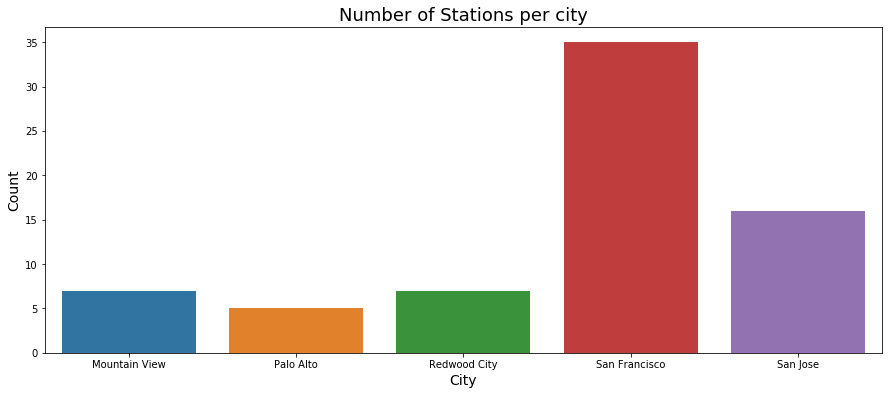

In [33]:
# Format data
agg1 = station.groupby('city').size().reset_index().rename(columns={0:'count'})
print(agg1)

# Bar Plot
sns.barplot(x = 'city', y = 'count', data = agg1)

# Set Labels
plt.xlabel('City', size=14)
plt.ylabel('Count', size=14)
plt.title('Number of Stations per city', size=18)

# Show Plot
plt.show()

** When were the stations installed? In which cities? **

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



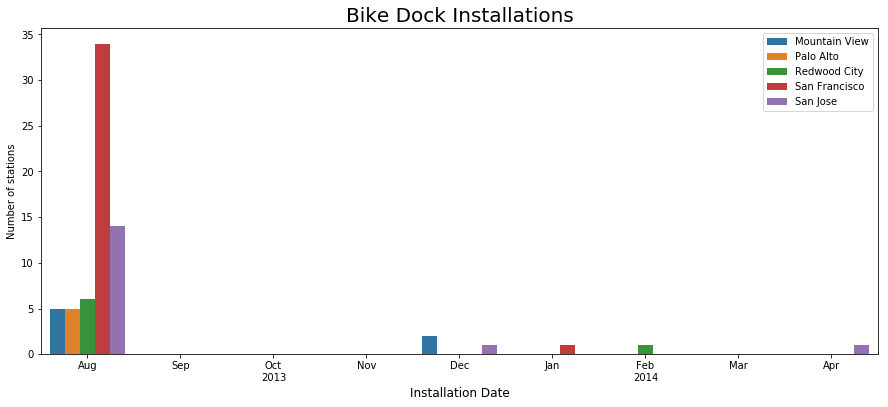

In [34]:
# Format Data
install = station.groupby(['installation_date', 'city'], as_index=False)['id'].count()

table = pd.pivot_table(install, 
                       values='id', 
                       index='installation_date', 
                       columns='city')\
                       .resample('M').sum()

agg2 = table.unstack().reset_index().rename(columns={0:'count'})

# Label for x-axis tick marks
ticks = ['Aug', 'Sep', 'Oct\n2013', 'Nov', 'Dec', 'Jan', 'Feb\n2014', 'Mar', 'Apr', 'May']

# Plot
sns.barplot(x = 'installation_date', y = 'count', hue='city', data = agg2)

# Set Labels
plt.xlabel('Installation Date', size=12)
plt.xticks(np.arange(0,9), ticks)
plt.ylabel('Number of stations')
plt.legend(loc='upper right')
plt.title('Bike Dock Installations', size=20)

# Show Plot
plt.show()

** Where are the stations located? **

In [35]:
init_notebook_mode(connected=True)

mapbox_access_token = 'pk.eyJ1IjoibWFsZmFjaW5pIiwiYSI6ImNqZ2Z0MXU3cDA2aXcycXFtbmo3bGd3bm0ifQ.v1sdJIQgvD-21VabfbcJ0Q'

lat = station['lat']
long = station['long']
text = station['name']
size = 600

data = Data([
        Scattermapbox(
            lat = lat,
            lon = long,
            mode = 'markers',
            marker = Marker(
                size = 17,
                color = 'rgb(255, 100, 100)',
                opacity = 0.7
            ),
            text = text,
            hoverinfo='text'
        )]
)

layout = Layout(
    title = 'Bike Sharing Stations - Mountain View',
    autosize = True,
    hovermode = 'closest',
    showlegend = False,
    mapbox = dict(
        accesstoken = mapbox_access_token,
        bearing = 0,
        center = dict(
            lat = 37.5,
            lon =-122.5
        ),
        pitch=0,
        zoom=8,
        style='light'
    ),
)

fig = dict(data = data, layout = layout)
plotly.offline.iplot(fig, filename = 'Bay Sharing Stations in San Francisco Bay Area')

** What is the average trip duration per city? **

The overall average trip duration is 16.46 minutes

            city  avg_duration
0  Mountain View     21.592546
1      Palo Alto     50.183507
2   Redwood City     28.502796
3  San Francisco     15.813575
4       San Jose     17.136340


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



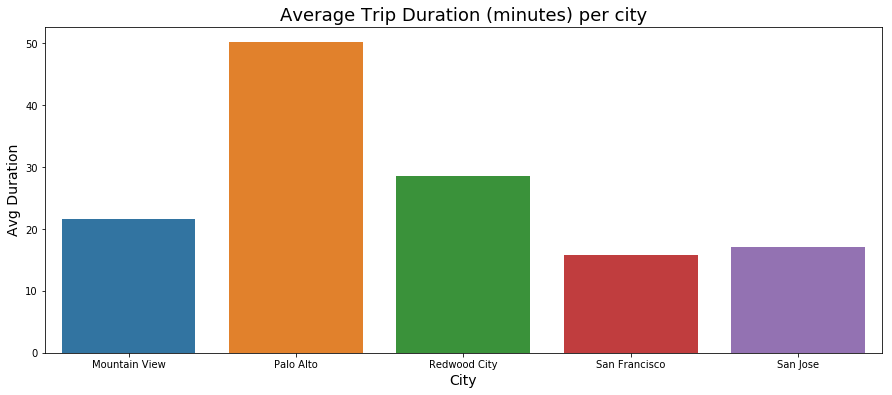

In [36]:
print('The overall average trip duration is {:.2f} minutes'.format(np.mean(trip['duration'])))
print()

# Format Data
agg3 = trip_clean.groupby('city')['duration'].mean().reset_index().rename(columns={'duration':'avg_duration'})
print(agg3)

# Plot
sns.barplot(x = 'city', y = 'avg_duration', data = agg3)

# Set Labels
plt.xlabel('City', size=14)
plt.ylabel('Avg Duration', size=14)
plt.title('Average Trip Duration (minutes) per city', size=18)
# Show Plot
plt.show()

** When do people ride the most often? **

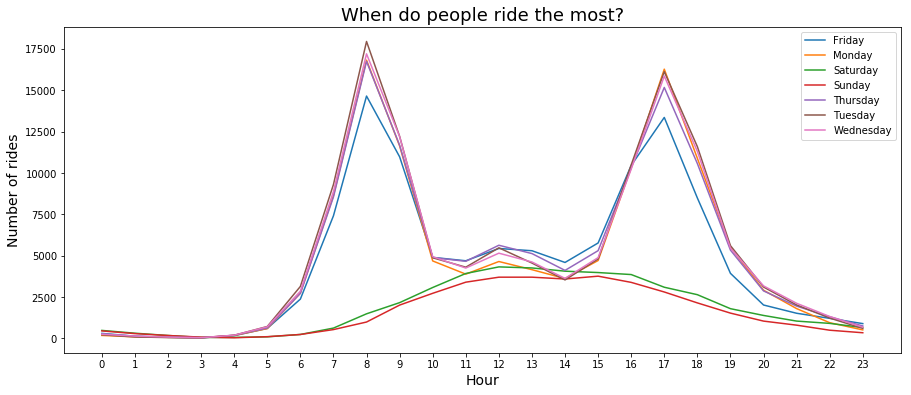

In [37]:
# Format Data
agg4 = trip_clean.set_index('start_date')
agg4['hour'] = agg4.index.hour
agg4['weekday'] = agg4.index.weekday_name
agg4 = agg4.groupby(['hour', 'weekday']).size().reset_index().rename(columns={0:'count'})

# Plot
weekday = agg4.weekday.unique()

for day in weekday:
    data = agg4[agg4['weekday'] == day]
    plt.plot(data['hour'], data['count'], label = day)

# Set Labels
plt.xlabel('Hour', size=14)
plt.xticks(np.arange(24))
plt.ylabel('Number of rides', size=14)
plt.title('When do people ride the most?', size=18)
plt.legend()

# Show Plot
plt.show()

** Which do people ride the longest/shortest? **

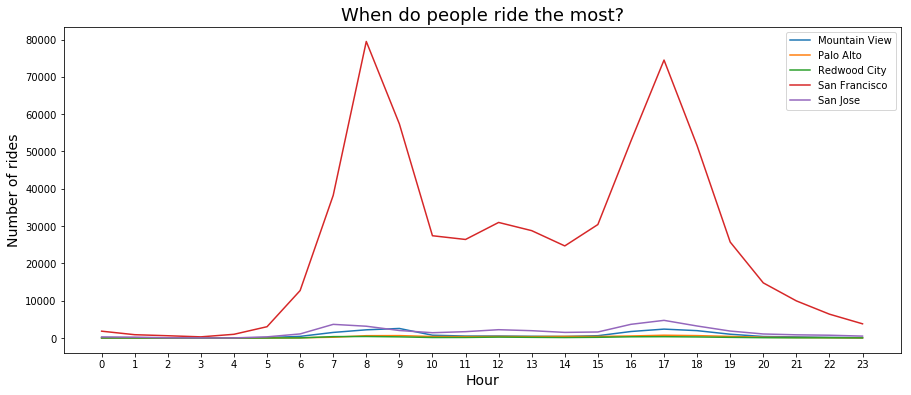

In [38]:
# Format Data
agg6 = trip_clean.set_index('start_date')
agg6['hour'] = agg6.index.hour
agg6['weekday'] = agg6.index.weekday_name
agg6 = agg6.groupby(['hour', 'city']).size().reset_index().rename(columns={0:'count'})

# Plot
cities = agg6.city.unique()

for city in cities:
    data = agg6[agg6['city'] == city]
    plt.plot(data['hour'], data['count'], label = city)

# Set Labels
plt.xlabel('Hour', size=14)
plt.xticks(np.arange(24))
plt.ylabel('Number of rides', size=14)
plt.title('When do people ride the most?', size=18)
plt.legend()

# Show Plot
plt.show()

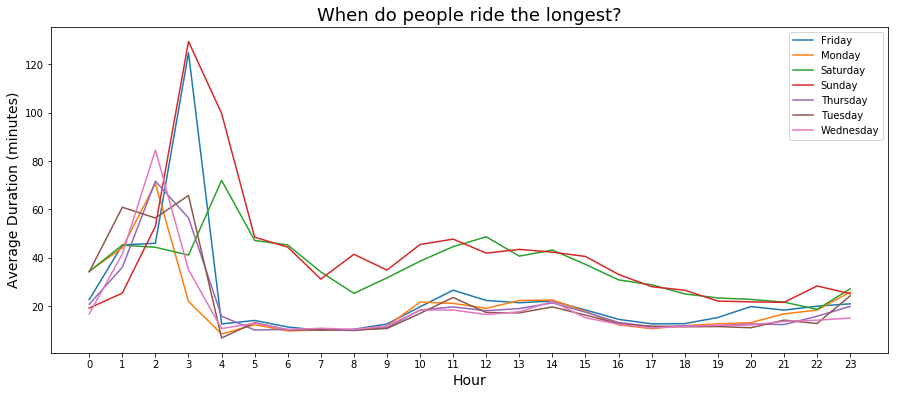

In [39]:
# Format Data
agg5 = trip_clean.set_index('start_date')
agg5['hour'] = agg5.index.hour
agg5['weekday'] = agg5.index.weekday_name
agg5 = agg5.groupby(['hour', 'weekday'])['duration'].mean().reset_index()

# Plot
weekday = agg5.weekday.unique()

for day in weekday:
    data = agg5[agg5['weekday'] == day]
    plt.plot(data['hour'], data['duration'], label = day)

# Set Labels
plt.xlabel('Hour', size=14)
plt.xticks(np.arange(24))
plt.ylabel('Average Duration (minutes)', size=14)
plt.title('When do people ride the longest?', size=18)
plt.legend()

# Show Plot
plt.show()

** Which city do people ride the most and longest/shortest? **

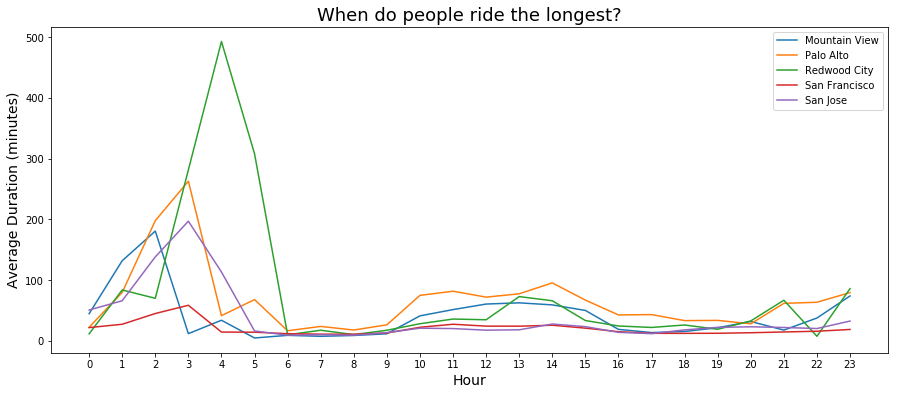

In [40]:
# Format Data
agg7 = trip_clean.set_index('start_date')
agg7['hour'] = agg7.index.hour
agg7['weekday'] = agg7.index.weekday_name
agg7 = agg7.groupby(['hour', 'city'])['duration'].mean().reset_index()

# Plot
cities = agg7.city.unique()

for city in cities:
    data = agg7[agg7['city'] == city]
    plt.plot(data['hour'], data['duration'], label = city)

# Set Labels
plt.xlabel('Hour', size=14)
plt.xticks(np.arange(24))
plt.ylabel('Average Duration (minutes)', size=14)
plt.title('When do people ride the longest?', size=18)
plt.legend()

# Show Plot
plt.show()

** What are the top riding routes? **

In [41]:
# Format Data
agg10 = trip_clean.groupby(['start_station_name', 'end_station_name', 'city']).size()\
                                                                              .reset_index()\
                                                                              .rename(columns={0:'count'})\
                                                                              .sort_values(by='count', ascending=False)\
                                                                              .reset_index(drop=True)
agg10.head(10)

,start_station_name,end_station_name,city,count
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco,6215
1,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,San Francisco,6164
2,Townsend at 7th,San Francisco Caltrain (Townsend at 4th),San Francisco,5041
3,2nd at Townsend,Harry Bridges Plaza (Ferry Building),San Francisco,4839
4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,San Francisco,4357
5,Embarcadero at Sansome,Steuart at Market,San Francisco,4269
6,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),San Francisco,3966
7,Steuart at Market,2nd at Townsend,San Francisco,3903
8,2nd at South Park,Market at Sansome,San Francisco,3627
9,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),San Francisco,3622


** Which months rain the most? **

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



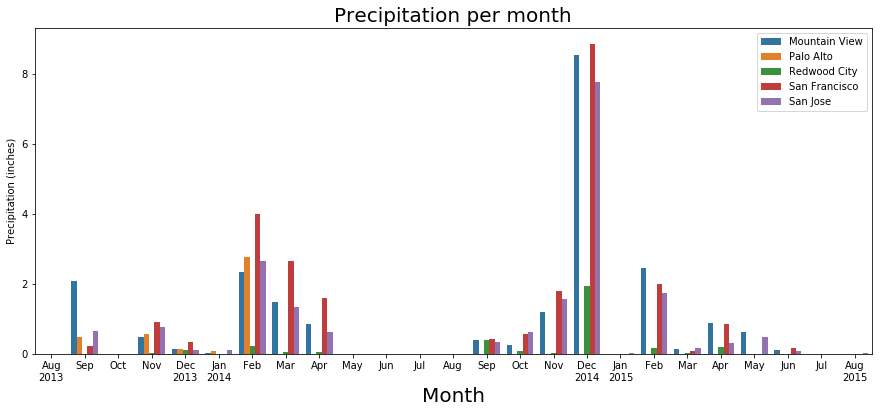

In [42]:
# Format Data
rain = weather_clean.groupby(['date', 'city'], as_index=False)['precipitation_inches'].sum()

table = pd.pivot_table(rain, 
                       values='precipitation_inches', 
                       index='date', 
                       columns='city')\
                       .resample('M').sum()

agg11 = table.unstack().reset_index().rename(columns={0:'count'})

# Label for x-axis tick marks
ticks = ['Aug\n2013', 'Sep', 'Oct', 'Nov', 'Dec\n2013', 'Jan\n2014', 'Feb', 'Mar', 'Apr', 'May',
         'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec\n2014', 'Jan\n2015', 'Feb', 'Mar', 'Apr', 
         'May', 'Jun', 'Jul', 'Aug\n2015']

# Plot
sns.barplot(x='date', y='count', hue='city', data=agg11)

# Adjust Labels
plt.xlabel('Month', size=20)
plt.xticks(np.arange(0,25), ticks)
plt.ylabel('Precipitation (inches)')
plt.legend(loc='upper right')
plt.title('Precipitation per month', size=20)

# Show Plot
plt.show()

** Do people ride less often when it's raining? **

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



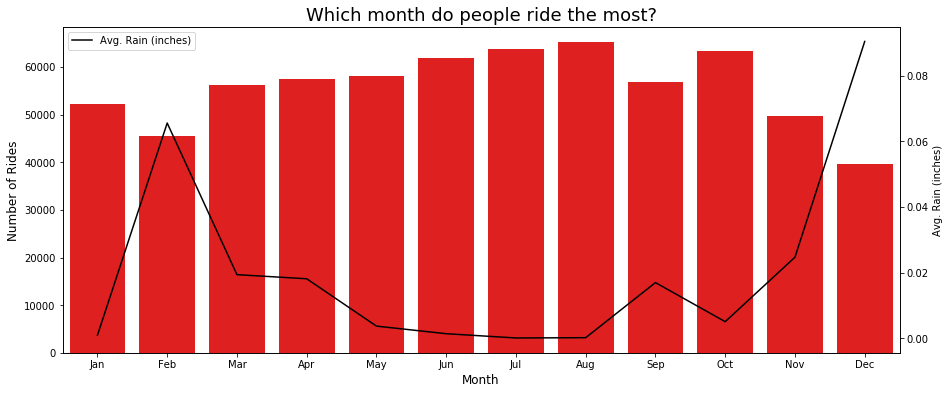

In [43]:
# Format data for bar plot
agg12 = trip_clean.set_index('start_date')
agg12 = agg12.groupby(agg12.index.month).size().reset_index().rename(columns={0:'count'})

# Format Data for line plot
agg13 = weather_clean.set_index('date')
agg13 = agg13.groupby(agg13.index.month)['precipitation_inches'].mean().reset_index().rename(columns={'precipitation_inches':'avg_rain'})

# Label months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the graph
sns.barplot(x = agg12.index, y = 'count', color='red',data=agg12)

# Label the graph
plt.xlabel('Month', size=12)
plt.xticks(np.arange(0, 12), months)
plt.ylabel('Number of Rides', size=12)
plt.title('Which month do people ride the most?', size=18)

# Line plot
x = agg13['date']
y = agg13['avg_rain']

# Plot the graph
ax2 = plt.twinx()
ax2.plot(y, color='black')
ax2.set_ylabel('Avg. Rain (inches)')
plt.legend(['Avg. Rain (inches)'])

# Show the Graph
plt.show()

** Do people take shorter/longer rides when it's raining?**

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



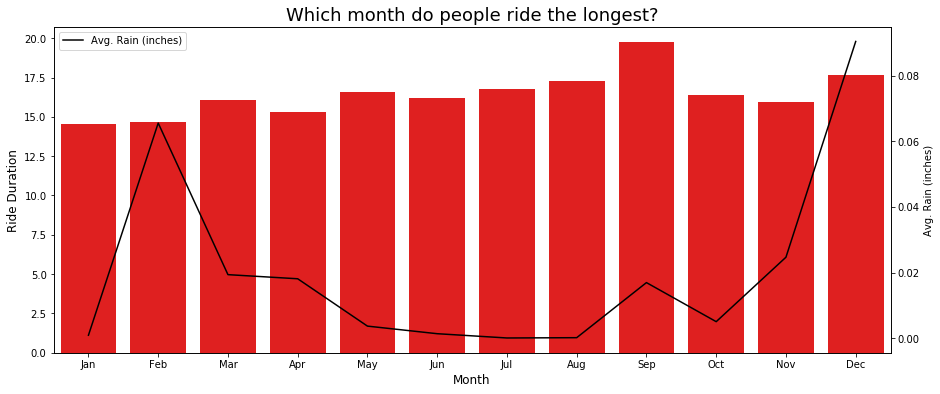

In [44]:
# Format data for bar plot
agg14 = trip_clean.set_index('start_date')
agg14 = agg14.groupby(agg14.index.month)['duration'].mean().reset_index()
 
# Format Data for line plot
agg15 = weather_clean.set_index('date')
agg15 = agg15.groupby(agg15.index.month)['precipitation_inches'].mean().reset_index()

# Label months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the graph
sns.barplot(x = agg14.index, y = 'duration', color='r',data=agg14)

# Label the graph
plt.xlabel('Month', size=12)
plt.xticks(np.arange(0, 12), months)
plt.ylabel('Ride Duration', size=12)
plt.title('Which month do people ride the longest?', size=18)

# Line plot
x = agg15['date']
y = agg15['precipitation_inches']

# Plot the graph
ax2 = plt.twinx()
ax2.plot(y, color='black')
ax2.set_ylabel('Avg. Rain (inches)')
plt.legend(['Avg. Rain (inches)'])

# Show the Graph
plt.show()

** How does temperature impact ridership? **

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



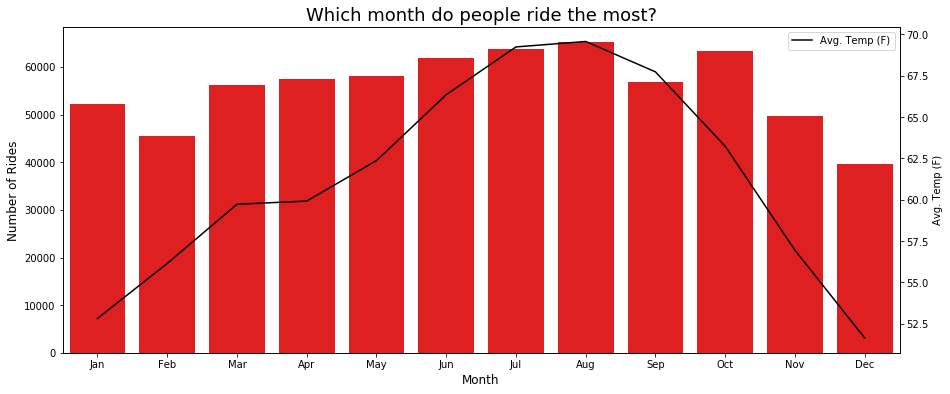

In [45]:
# Format data for bar plot
agg16 = trip_clean.set_index('start_date')
agg16 = agg16.groupby(agg16.index.month).size().reset_index().rename(columns={0:'count'})
        
# Format Data for line plot
agg17 = weather_clean.set_index('date')
agg17 = agg17.groupby(agg17.index.month)['mean_temperature_f'].mean().reset_index()

# Label months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the graph
sns.barplot(x = agg16.index, y = 'count', color='red',data=agg16)

# Label the graph
plt.xlabel('Month', size=12)
plt.xticks(np.arange(0, 12), months)
plt.ylabel('Number of Rides', size=12)
plt.title('Which month do people ride the most?', size=18)

# Line plot
x = agg17['date']
y = agg17['mean_temperature_f']

# Plot the graph
ax2 = plt.twinx()
ax2.plot(y, color='black')
ax2.set_ylabel('Avg. Temp (F)')
plt.legend(['Avg. Temp (F)'])

# Show the Graph
plt.show()

** How does temperature impact ride duration?**

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



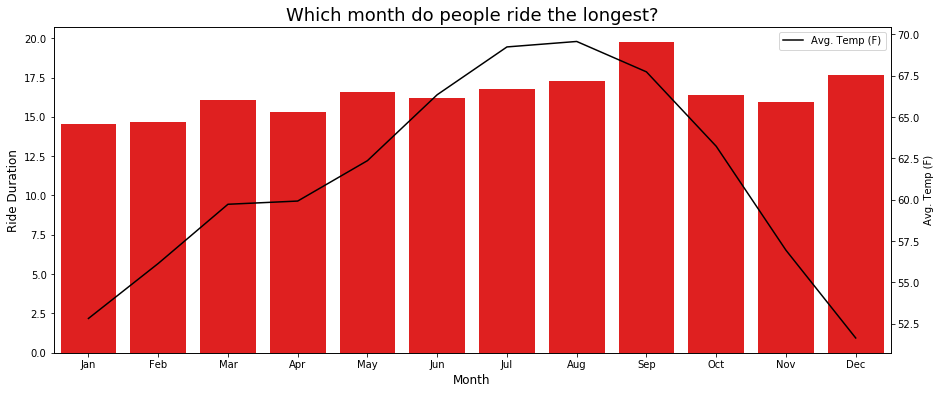

In [46]:
# Format data for bar plot
agg18 = trip_clean.set_index('start_date')
agg18 = agg18.groupby(agg18.index.month)['duration'].mean().reset_index()
        
# Format Data for line plot
agg19 = weather_clean.set_index('date')
agg19 = agg19.groupby(agg19.index.month)['mean_temperature_f'].mean().reset_index()

# Label months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the graph
sns.barplot(x = agg18.index, y = 'duration', color='red',data=agg18)

# Label the graph
plt.xlabel('Month', size=12)
plt.xticks(np.arange(0, 12), months)
plt.ylabel('Ride Duration', size=12)
plt.title('Which month do people ride the longest?', size=18)

# Line plot
x = agg19['date']
y = agg19['mean_temperature_f']

# Plot the graph
ax2 = plt.twinx()
ax2.plot(y, color='black')
ax2.set_ylabel('Avg. Temp (F)')
plt.legend(['Avg. Temp (F)'])

# Show the Graph
plt.show()

# Machine Learning

In [94]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from io import StringIO
import re
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import scipy.optimize as optimization

Under the trips dataframe, we have a column named subscription_type which states a trip was taken either by a "Subscriber" or a "Customer" (i.e. non-subscriber). In this model, I'm going to use data to predict wheather a trip was taken by either a Subscriber or a Customer.

### Classify whether the rider is a subscriber or a customer

In [48]:
# Make start_date a date only field to merge dataframes
trip_clean.loc[:, 'date_only'] = [d.date() for d in trip_clean.loc[:, 'start_date']]
trip_clean.loc[:, 'date_only'] = pd.to_datetime(trip_clean.loc[:, 'date_only'])

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [49]:
# Merge trip and weather information
df = pd.merge(trip_clean, weather_clean, left_on=['date_only', 'city'], right_on=['date', 'city'], how='left')

In [50]:
# Keep only features to be used in machine learning model
col_to_keep = ['duration', 'start_station_id', 'end_station_id', 'mean_temperature_f', 'mean_wind_speed_mph',
               'precipitation_inches', 'subscription_type']

ml = df[col_to_keep]

In [51]:
ml.head()

,duration,start_station_id,end_station_id,mean_temperature_f,mean_wind_speed_mph,precipitation_inches,subscription_type
0,1.050000,66,66,68.0,11.0,0.0,Subscriber
1,1.166667,10,10,72.0,7.0,0.0,Subscriber
2,1.183333,27,27,70.0,5.0,0.0,Subscriber
3,1.283333,10,10,72.0,7.0,0.0,Subscriber
4,1.383333,66,67,68.0,11.0,0.0,Subscriber


In [52]:
# Set model baseline
print('Subscribers are {:2.2%} of the dataset.'\
      .format(len(ml[ml['subscription_type'] == 'Subscriber'])/len(ml)))
print('There are {} observations that are subscribers'\
      .format(len(ml[ml['subscription_type'] == 'Subscriber'])))
print()
print('Customers are {:2.2%} of the dataset.'\
      .format(len(ml[ml['subscription_type'] == 'Customer'])/len(ml)))
print('There are {} Customer observations'\
      .format(len(ml[ml['subscription_type'] == 'Customer'])))
print()
print('There are {} observations in this dataset'.format(len(ml)))

Subscribers are 84.62% of the dataset.
There are 566698 observations that are subscribers

Customers are 15.38% of the dataset.
There are 102965 Customer observations

There are 669663 observations in this dataset


Notice that we have imbalanced classes with a 21:4 ratio

In [53]:
# Set features and labels
feature = ml.iloc[:, 0:-1]
label = ml['subscription_type']

### Run different models and check accuracy

### LinearSVC

In [54]:
linear = LinearSVC()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

In [55]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   Customer       0.93      0.14      0.25     25736
 Subscriber       0.87      1.00      0.93    141680

avg / total       0.87      0.87      0.82    167416



In [56]:
# Linear SVC with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.88
Best parameters:  {'C': 10}


### Logistic Regression

In [57]:
logistic = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

In [58]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   Customer       0.92      0.23      0.37     25736
 Subscriber       0.88      1.00      0.93    141680

avg / total       0.88      0.88      0.85    167416



In [59]:
# Linear SVC with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.88
Best parameters:  {'C': 1}


### Naive Bayes

In [60]:
bayes = MultinomialNB()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

bayes.fit(X_train, y_train)
y_pred = bayes.predict(X_test)

In [61]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   Customer       0.78      0.36      0.50     25736
 Subscriber       0.89      0.98      0.94    141680

avg / total       0.88      0.89      0.87    167416



In [62]:
# Linear SVC with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'alpha': [0.1, 1, 10]}
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.89
Best parameters:  {'alpha': 0.1}


### Random Forest

In [63]:
forest = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [64]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   Customer       0.74      0.62      0.67     25736
 Subscriber       0.93      0.96      0.95    141680

avg / total       0.90      0.91      0.90    167416



In [65]:
# Random Forest Classifier with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'n_estimators': [10, 15, 20]}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.90
Best parameters:  {'n_estimators': 20}


Feature Importance

In [66]:
print('Feature Importance')
print('===========================')

for index, value in enumerate(forest.feature_importances_):
    print('{:.2f}  {}'.format(value, col_to_keep[index]))

Feature Importance
0.55  duration
0.13  start_station_id
0.13  end_station_id
0.10  mean_temperature_f
0.09  mean_wind_speed_mph
0.01  precipitation_inches


Based on this model, precipitation and wind speed have less than a 10% impact on the model. We can safely drop it in future model improvements

#### Feature Engineering

###### Get distance between two stations (in miles)

Get the distance between any two stations. End goal is to create a distance/duration ratio to add to the model. Subscribers tend to get to where they are going as fast as possible while customers tend to take longer rides in terms of duration. If a rider takes longer duration to go between the same two stations, this could help the model to make a correct prediction.

In [67]:
import math

def distances(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 3959 # km
    # miles 3959
    # km = 6371
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [68]:
# Create dictionary with coordinates for each station
station_coordinates_map = dict(zip(station['id'], zip(station['lat'], station['long'])))

ml_agg = trip_clean.groupby(['start_station_id', 'end_station_id']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)

ml_agg['origin'] = ml_agg['start_station_id'].map(station_coordinates_map)
ml_agg['destination'] = ml_agg['end_station_id'].map(station_coordinates_map)

# Re-arange columns
ml_agg = ml_agg[['start_station_id', 'origin', 'end_station_id', 'destination', 'count']]

# Add distance column to agg dataframe
distance = []

for start, end in zip(ml_agg.origin, ml_agg.destination):
    d = distances(start, end)
    distance.append(d)

ml_agg['distance'] = distance


ml_agg.head()

,start_station_id,origin,end_station_id,destination,count,distance
0,69,"(37.7766, -122.39547)",65,"(37.771058, -122.402717)",6215,0.550734
1,50,"(37.795392, -122.394203)",60,"(37.80477, -122.403234)",6164,0.814261
2,65,"(37.771058, -122.402717)",70,"(37.776617, -122.39526)",5041,0.559839
3,61,"(37.780526, -122.39028799999998)",50,"(37.795392, -122.394203)",4839,1.049216
4,50,"(37.795392, -122.394203)",61,"(37.780526, -122.39028799999998)",4357,1.049216


In [69]:
# Add city in integer format
cities_dict = {'San Francisco':1, 'San Jose':2, 'Mountain View':3, 'Redwood City':4, 'Palo Alto': 5}
df['cities'] = df['city'].map(cities_dict)

# Add time series to model features
time = pd.DatetimeIndex(df['start_date'])
df['hour'] = time.hour
df['weekday'] = time.weekday

# Create map with station_id combination as tuple dict
stations_distance_dict = dict(zip(zip(ml_agg['start_station_id'], ml_agg['end_station_id']), ml_agg['distance']))

# Add distance to model features
df['stations_tuple'] = tuple(zip(df['start_station_id'], df['end_station_id']))
df['distance'] = df['stations_tuple'].map(stations_distance_dict)
df['distance_duration_ratio'] = df['distance'] / df['duration']

In [70]:
selected_features = ['duration', 'distance_duration_ratio', 'start_station_id', 'end_station_id', 'mean_temperature_f', 'subscription_type']

ml_1 = df[selected_features]

In [71]:
# Set features and labels
feature = ml_1.iloc[:, 0:-1]
label = ml_1['subscription_type']

In [108]:
forest = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [109]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   Customer       0.69      0.62      0.65     25736
 Subscriber       0.93      0.95      0.94    141680

avg / total       0.90      0.90      0.90    167416



In [110]:
# Random Forest Classifier with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'n_estimators': [15, 20, 30]}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.90
Best parameters:  {'n_estimators': 30}


In [111]:
print('Feature Importance')
print('===========================')

for index, value in enumerate(forest.feature_importances_):
    print('{:.2f}  {}'.format(value, selected_features[index]))

Feature Importance
0.32  duration
0.40  distance_duration_ratio
0.08  start_station_id
0.08  end_station_id
0.12  mean_temperature_f


### ==== Future Improvements ===

# Find out when stations are empty

In [76]:
status.shape

(71984434, 3)

In [77]:
# Find station capacity
status['station_capacity'] = status['bikes_available'] / (status['bikes_available'] + status['docks_available'])

# Add city
station_city_dict = dict(zip(station['id'], station['city']))
status['city'] = status['station_id'].map(station_city_dict)

# 240 rows have 0 bikes available and 0 docks available. Drop those rows.
status = status[pd.notnull(status['station_capacity'])]

In [78]:
status.shape

(71984194, 5)

**Feature engineering**

Let's create a model that'll allow us to predict when stations are going to empty.

As we've seen from the graph above, riders tend to ride the most during the week at commute times (between 7 and 9 in the morning, and 4 and 6 in the afternoon). Commute times is also when stations are being used the most and therefore have a greater likelihood of not having bikes available when riders would need a ride. 

Since we know this, let's create commute time columns for our model.

In [86]:
status = status.reset_index()


,index,time,station_id,bikes_available,docks_available,station_capacity,city
0,0,2013-08-29 12:06:01,2,2,25,0.074074,San Jose
1,1,2013-08-29 12:07:01,2,2,25,0.074074,San Jose
2,2,2013-08-29 12:08:01,2,2,25,0.074074,San Jose
3,3,2013-08-29 12:09:01,2,2,25,0.074074,San Jose
4,4,2013-08-29 12:10:01,2,2,25,0.074074,San Jose


In [89]:
del status['index']
status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984194 entries, 0 to 71984193
Data columns (total 6 columns):
time                datetime64[ns]
station_id          int64
bikes_available     int64
docks_available     int64
station_capacity    float64
city                object
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 3.2+ GB


In [101]:
def bike_availability(x):
    if x >= n_bikes:
        return 1
    else:
        return 0

def addition(a, b, c):
    return(b + c*a)

start_times = ['07:00:00', '07:30:00', '08:00:00', '08:30:00', '09:00:00', '16:00:00', '16:30:00', '17:00:00', '17:30:00', '18:00:00']
n_bikes=2
delta = pd.Timedelta(29, unit='m')

unique_station_ids = status['station_id'].unique()

# Subset status dataframe by station_id
def empty_stations(station, bike_qty, day_of_week):
    df = status[status['station_id'] == station]
    df.index = df['time']
    df.index = df.index.map(lambda x: x.replace(second=0))
    return df

all_stations = []
headers = []

for i in unique_station_ids:
    df = empty_stations(i, bike_qty = 2, day_of_week = 2)
    single_station = []
    for j in start_times:
        start_time = pd.to_datetime(j)
        end_time = start_time + delta
        df1 = df.between_time(start_time.time(), end_time.time())
        data1 = df1.index.minute
        data2 = np.array(df1.bikes_available)
        popt, pcov = optimization.curve_fit(addition, data1, data2)
        single_station.append(popt[1])
    all_stations.append(single_station)
    headers.append(i)
    
# Reshape data
df = pd.DataFrame(all_stations)
df.columns = start_times
df.index = headers
df = df*29

In [102]:
df.head()

,07:00:00,07:30:00,08:00:00,08:30:00,09:00:00,16:00:00,16:30:00,17:00:00,17:30:00,18:00:00
2,0.071571,-0.008874,-1.349618,-0.840703,-1.088687,1.538212,1.363790,0.518116,-0.204962,-0.325365
3,-0.050659,-0.026502,0.022995,0.071825,0.015884,-0.045014,-0.092257,0.076777,0.014564,0.036663
4,0.219059,0.179331,0.471934,0.148559,0.146814,-0.245785,-0.428358,-0.132463,0.088545,-0.163810
5,0.007127,0.043489,0.142568,0.190728,0.201190,-0.198139,-0.110377,-0.162401,-0.039427,-0.045294
6,-0.025032,0.735592,0.131959,0.137939,-0.027278,-0.205531,-0.556993,-0.381991,0.001361,0.108984


In [103]:
ml = df[:]
ml['station_id'] = ml.index
ml = pd.melt(ml, id_vars = ['station_id'])
ml.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,station_id,variable,value
0,2,07:00:00,0.071571
1,3,07:00:00,-0.050659
2,4,07:00:00,0.219059
3,5,07:00:00,0.007127
4,6,07:00:00,-0.025032
